In [1]:
%pylab notebook

import pandas as pd
import numpy as np
import datetime
import os

import ipywidgets as widgets

from cognite.config import configure_session
from cognite.v05.timeseries import get_datapoints_frame, get_timeseries
from cognite.v05.assets import get_asset, get_assets, get_asset_subtree
from cognite.v05.events import get_events, get_event, search_for_events

Populating the interactive namespace from numpy and matplotlib


In [2]:
configure_session(os.environ.get('Public_key'), 'publicdata')

In [3]:
p_in_tag  = 'VAL_23-PT-92532:X.Value'
T_in_tag  = 'VAL_23_TT_92532:Z.X.Value'
Q_tag     = 'VAL_23-FT-92537-01:X.Value'
p_out_tag = 'VAL_23-PT-92539:X.Value'
T_out_tag = 'VAL_23_TT_92536:Z.X.Value'
all_tags  = [p_in_tag, T_in_tag, Q_tag, T_out_tag, p_out_tag]

In [158]:
# Training - test set
# Question: Why not random?

train_start = datetime.datetime(2014, 1, 1)
train_end   = datetime.datetime(2016, 1, 1)
predict_end = datetime.datetime(2017, 1, 1)

start = train_start
end = predict_end
data = get_datapoints_frame(all_tags, 
                            start=start, 
                            end=end,
                            granularity='10m', 
                            aggregates=['avg'])

In [159]:
df = data.fillna(method='ffill')
df = df.fillna(method='bfill')

In [160]:
train_cond = df.timestamp < train_end.timestamp()*1000
df_train = df[train_cond]
df_test  = df[~train_cond]

In [161]:
X_train = df_train.drop(['timestamp'], axis=1)
X_test  = df_test.drop(['timestamp'], axis=1)
t_train = pd.to_datetime(df_train.timestamp, unit='ms')
t_test  = pd.to_datetime(df_test.timestamp, unit='ms')

In [162]:
# ****** The KMeans Approach *******
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3)
labels = km.fit_predict(X_train)

<IPython.core.display.Javascript object>


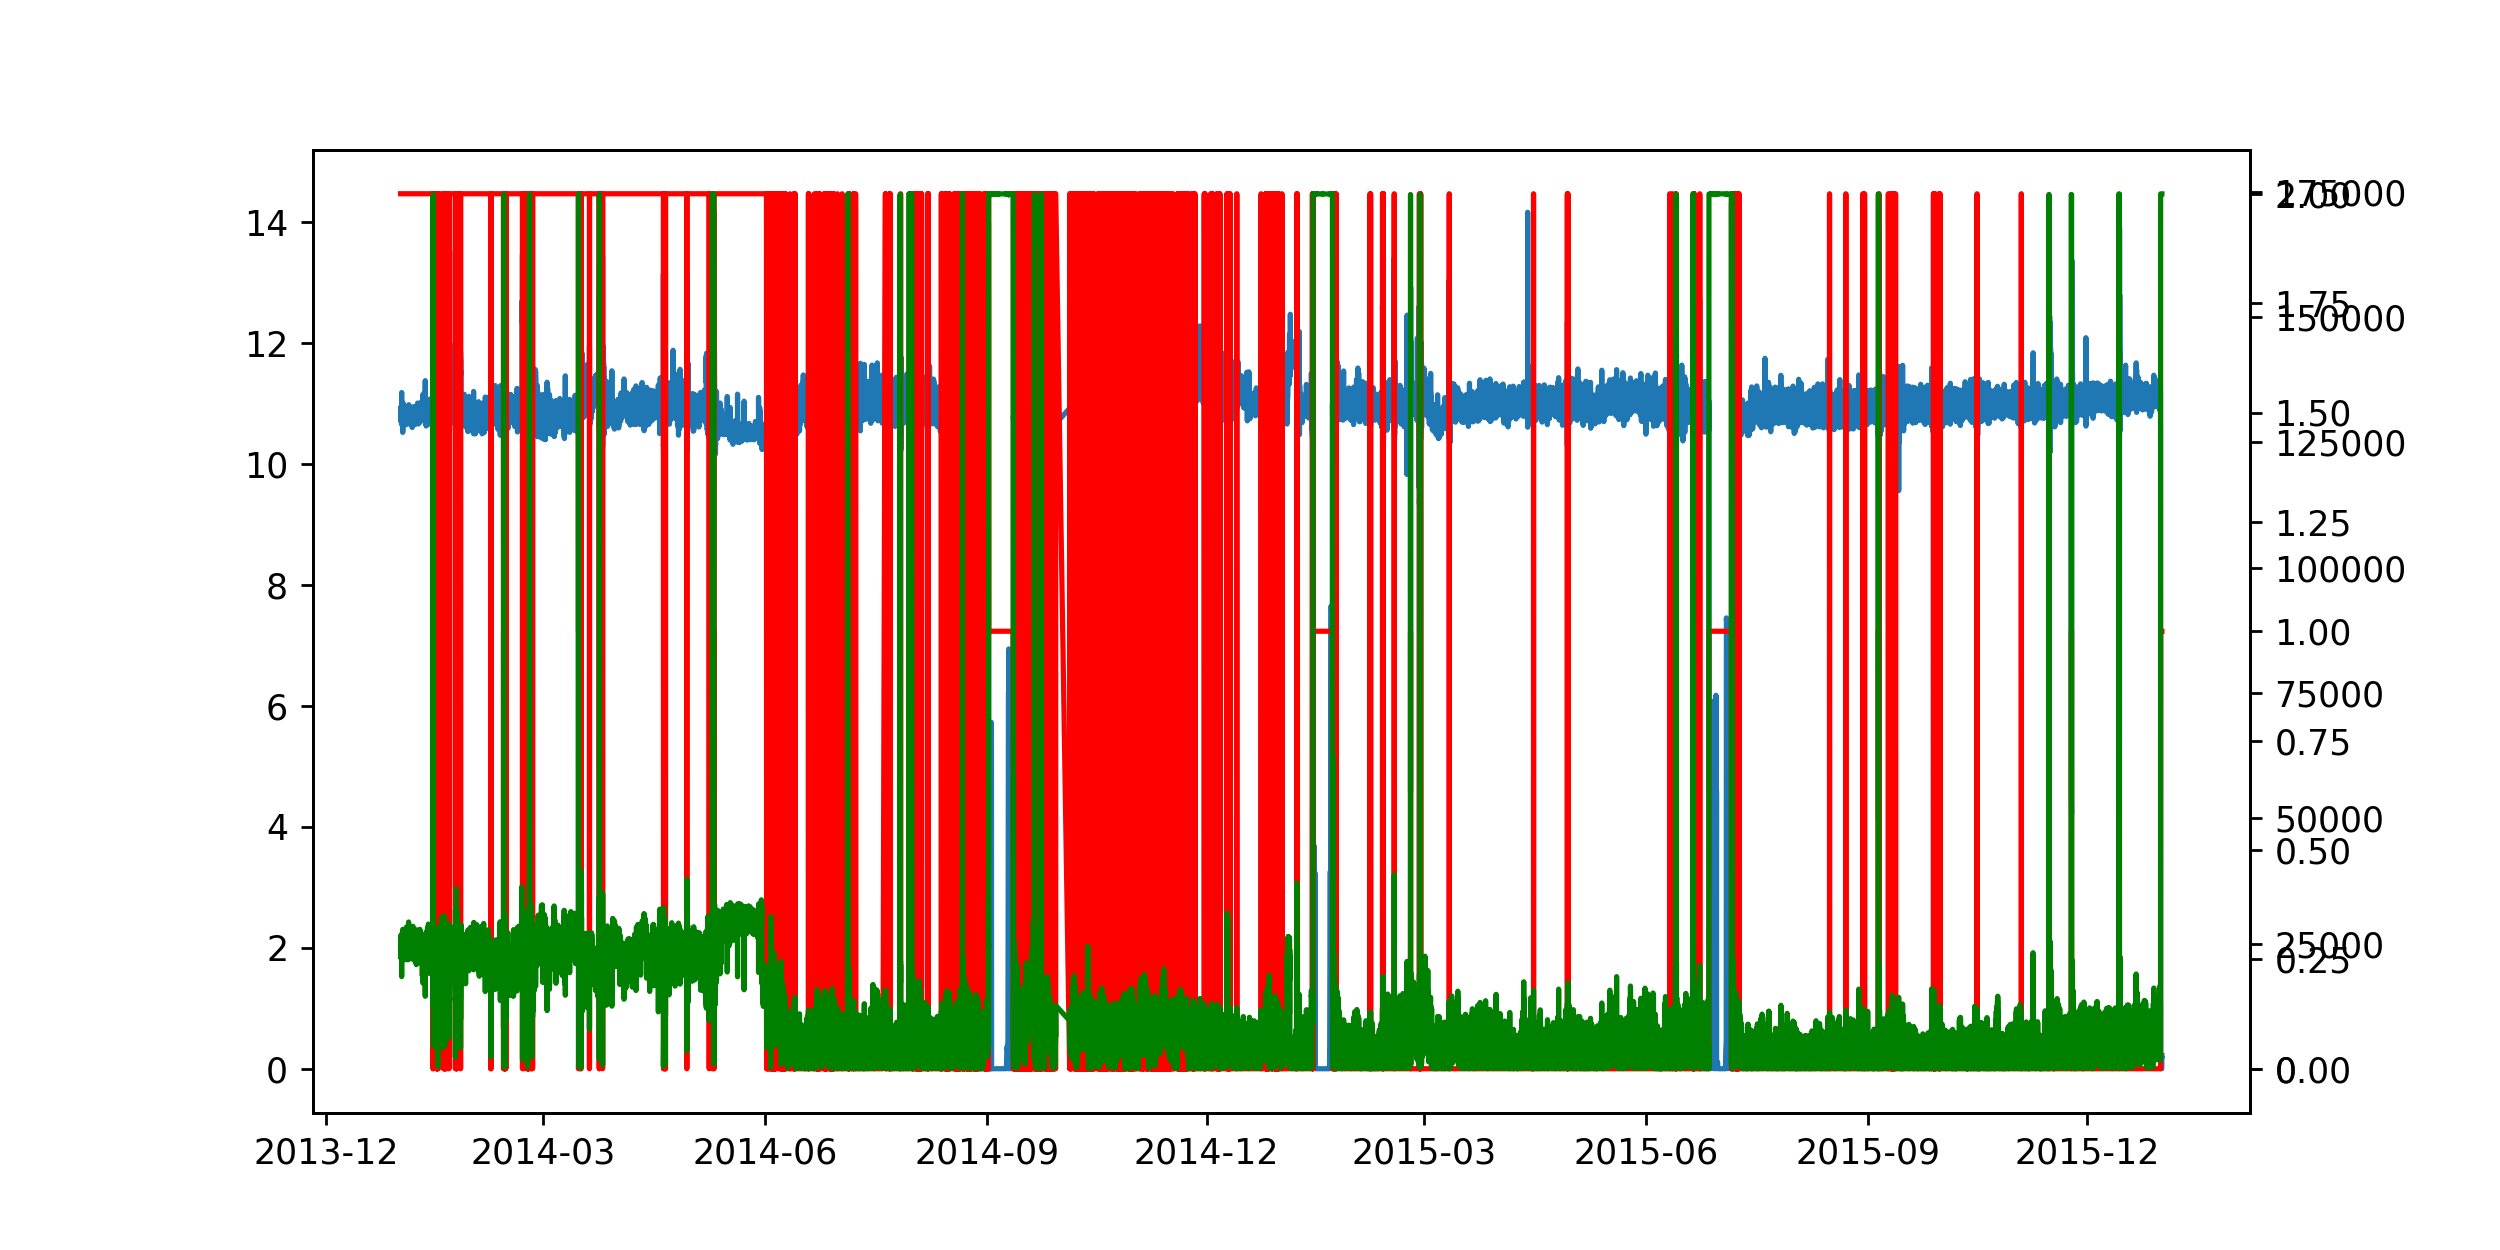

In [163]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_train, df_train[p_out_tag+'|average'])
ax2 = ax.twinx()
ax2.plot(t_train, labels, color='red')

In [164]:
Z1 = km.cluster_centers_[0]
Z2 = km.cluster_centers_[1]
L1 = np.sum(np.abs(X_train - Z1)**2, axis=1)**0.5
L2 = np.sum(np.abs(X_train - Z2), axis=1)
ax3 = ax.twinx()
plt.plot(t_train, L1, color='green', label='L1')
#plt.plot(t_train, L2, color='black', label='L2')

<IPython.core.display.Javascript object>


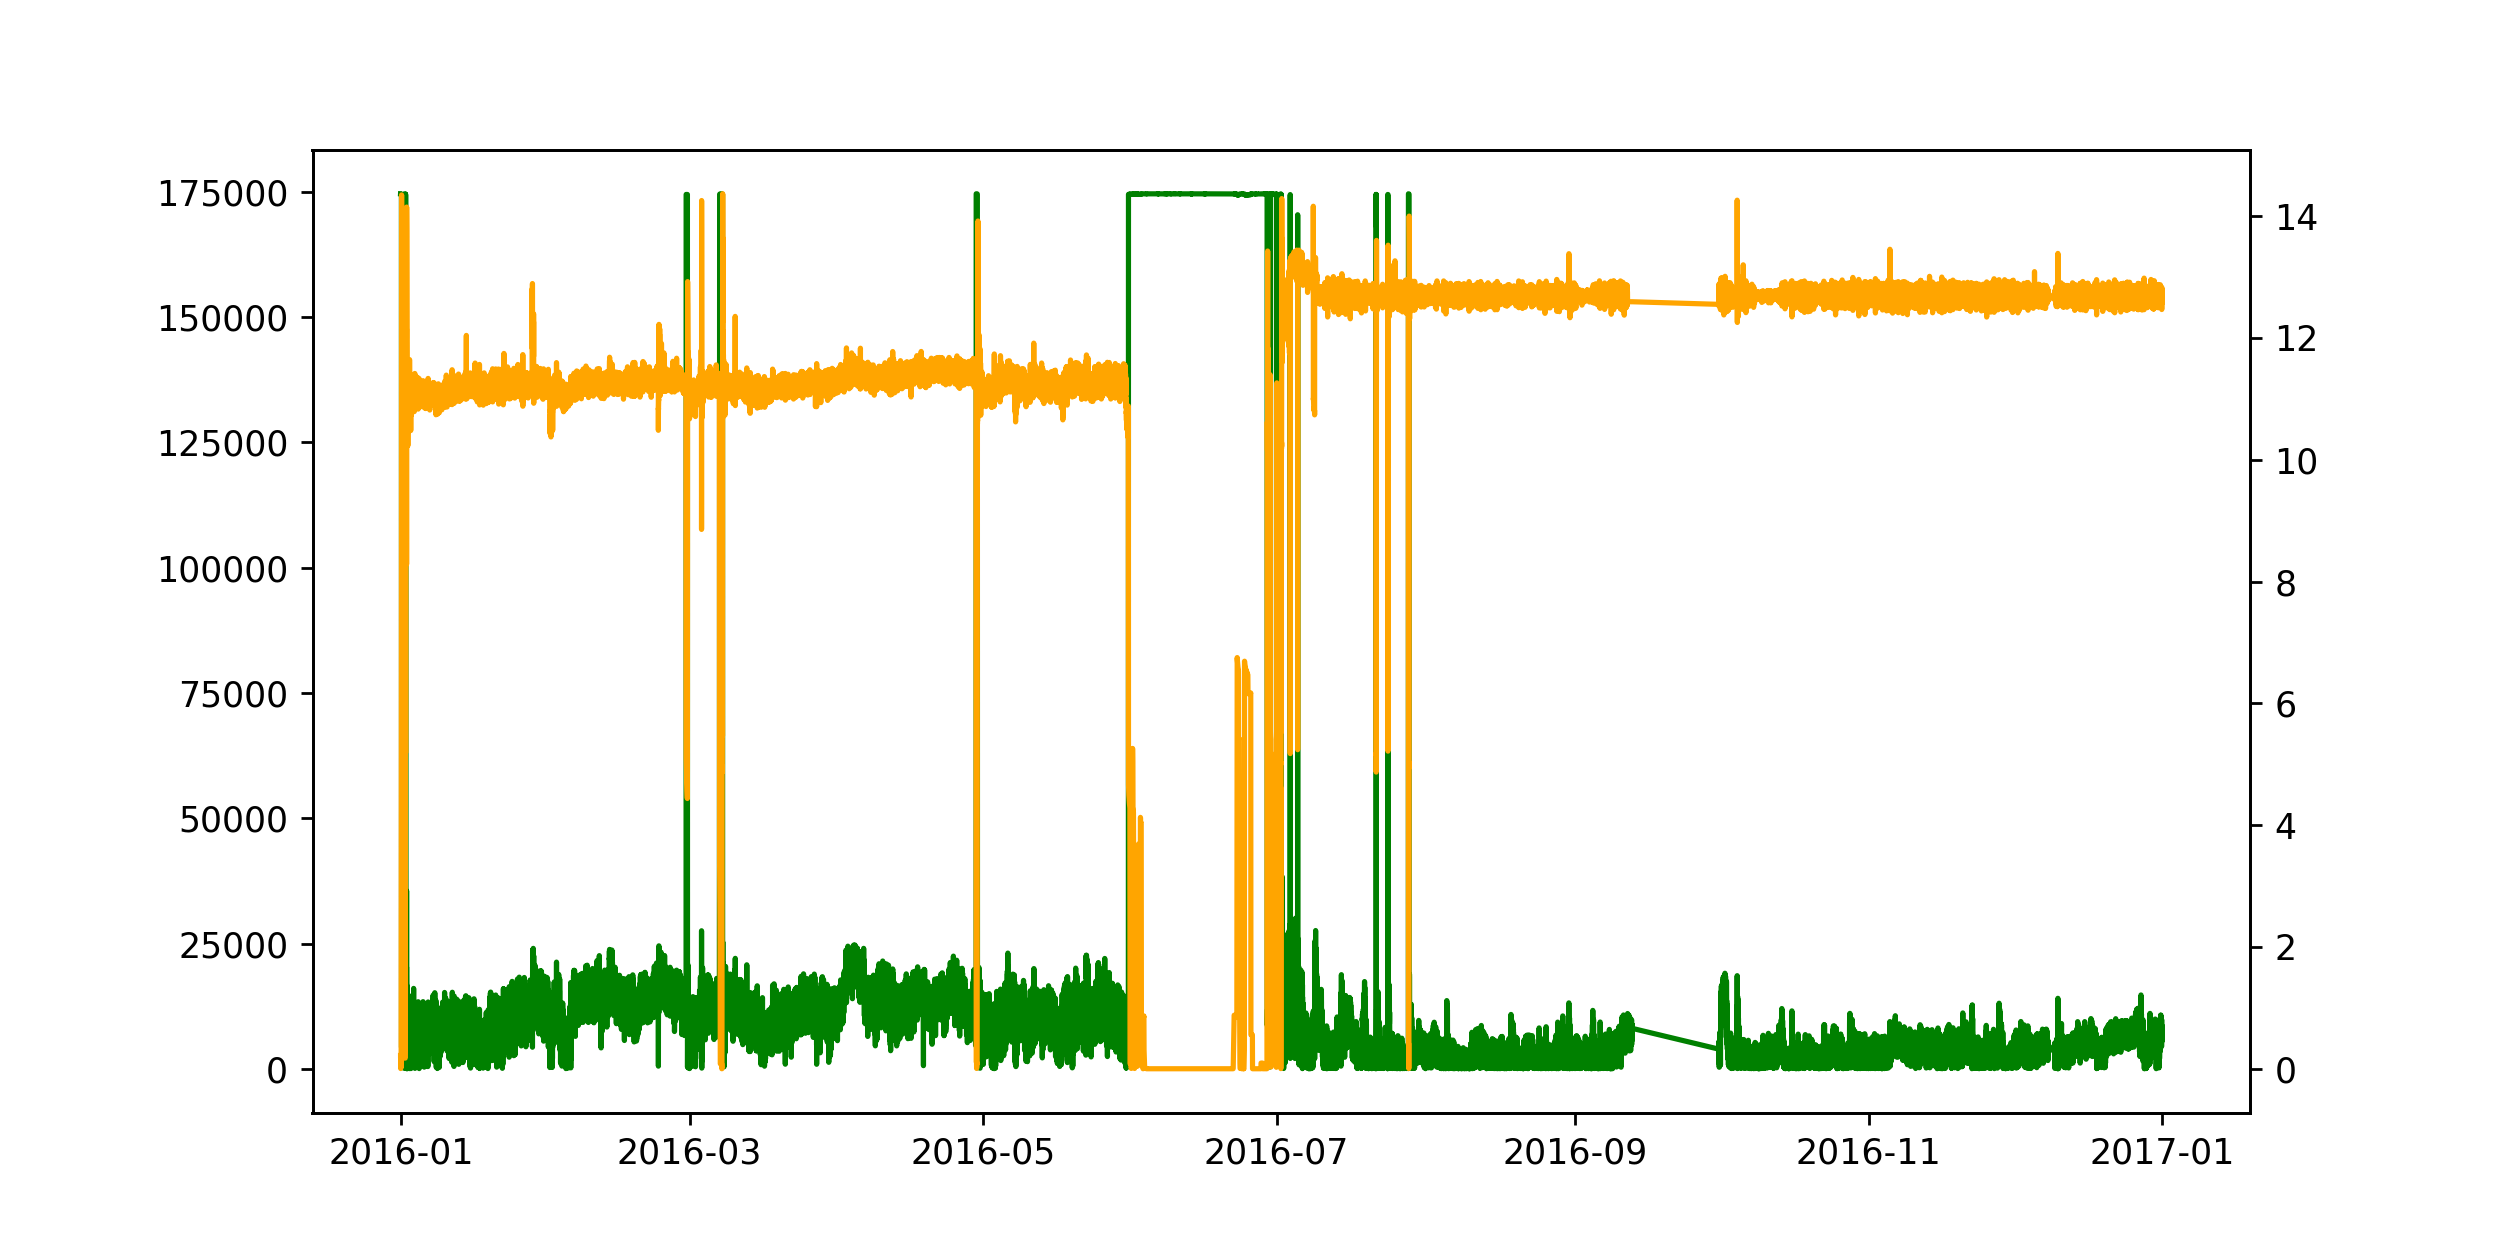

In [165]:
P1 = np.sum(np.abs(X_test - Z1)**2, axis=1)**0.5
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(t_test, P1, color='green')
ax.twinx().plot(t_test, df_test[p_out_tag+'|average'], color='orange')